# Repeating previous experiments using networks with sparse structure

Strategy: use the code you have already. (arch = mlp_noreluout_lastlayernottrainable)
- Initialize weights 1 to have the correct sparsity structure
- Initialize weights 2 to 1
- Use a special type of optimizer to only update non-zero entries

Some properties of the experiments:
- Only looking at 3-layer networks
- Layer2-to-layer3 weights are fixed to equal 1 (not trainable)
- Generated inputs are iid
- No output relu (output is just the sum of the second-layer neurons)

These experiments are akin to previous experiments: looking to see how often we get good performance (0 loss) for different network structures. In particular, we are interested in the number of global and local optima, which we evaluate using the final loss and the final gap between estimated and true weights.

### Experiment Set 1

The first set of experiments involve generating true labels using the same network used to learn those weights. Networks with 5 inputs and 5$r$ hidden layers for $r = 1, 2, 3, 4$ were tested for sparse structure 1 (each neuron connected to one input). For sparse structure 2, networks had 5 inputs. We tested hidden layer sizes of 10 and 3. For both cases, we tested $s = 1, 2, 3, 4$ where $s$ is the number of inputs (randomly chosen) each neuron was connected to.

### Experiment Set 2

The second set of experiments involve generating true labels using a fully-connected network while learning with a sparser structure. The true labels were generated using a fully-connected 10-3-1 network (no relu out, all layer2-layer3 weights = 1). We tested the performance of the sparse networks from experiment set 1 (input size = 10). For sparse structure 2, we set input size to 10 and tested hidden layer sizes of 3 and 15. We also tested $s = 1, 2, 3, 4, 5, 6, 7, 8$.

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import tensorflow as tf
import numpy as np
import os,time,seaborn,pickle
import matplotlib.pyplot as plt
import arch,dl_utils,utils

np.set_printoptions(precision=2,suppress=True)
gpu_id = 1

%matplotlib inline

maindir = './temp_sparse/'
q = 0

In [2]:
# Same as graph_builder_wrapper except for sparser structures
# CURRENTLY ONLY WORKS WITH mlp_noreluout_lastlayernottrainable
# (M is a mask for only the weights from input to hidden 1 layers)
def graph_builder_wrapper_sparse(input_dict,M,build_func=arch.mlp,lr_initial=0.01,max_save=100):
    graph = build_func(input_dict)
    
    # Loss
    y = tf.placeholder(tf.float32, shape=[None,1])
    total_loss = dl_utils.loss(y, graph['yhat'])
    
    # W gap
    w = {k:tf.placeholder(tf.float32, shape=[None,None]) for k in graph if 'weights' in k}
    total_w_gap = dl_utils.w_gap(w, {k:graph[k] for k in graph if 'weights' in k})
    
    # Optimizer
    learning_rate = tf.Variable(lr_initial, name='learning_rate')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads = optimizer.compute_gradients(total_loss)
    modified_grads = []
    for gv in grads:
        if gv[0] is None: modified_grads.append(gv)
        else: modified_grads.append((tf.multiply(gv[0], M), gv[1]))
    opt_step = optimizer.apply_gradients(modified_grads)
    
    graph['y'] = y
    graph['w'] = w
    graph['opt_step'] = opt_step
    graph['total_loss'] = total_loss
    graph['total_w_gap'] = total_w_gap
    graph['learning_rate'] = learning_rate
    graph['saver'] = tf.train.Saver(max_to_keep=100)
    return graph

def generate_two_plots(all_final_loss,all_final_w_gaps,all_initial_w_gaps):
    f, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
    seaborn.regplot(all_initial_w_gaps,all_final_loss,ax=ax1)
    ax1.set(xlabel='initial w gap', ylabel='final loss')
    seaborn.regplot(all_final_w_gaps,all_final_loss,ax=ax2)
    ax2.set(xlabel='final w gap', ylabel='final loss')

# Experiment set 1: true labels generated with sparse architectures

### Sparse structure 1

Each hidden neuron goes to one input

In [3]:
# Sparse structure 1: each hidden neuron goes to one input
def generate_sparse_w_1(p,r,seed=0):
    np.random.seed(seed)
    def sparse_mask_1(p,r): return np.repeat(np.eye(p),r,axis=0)
    M = sparse_mask_1(p,r)
    Z = np.random.normal(0,1,[p*r,p]) # std is 1 since each hidden neuron is connected to 1 input
    W1 = (Z*M).T
    W2 = np.ones([h,1])
    return {'weights1':W1,'weights2':W2},M.T

In [ ]:
num_sims = 100 # number of simulations
N = 10000      # number of samples

# Network parameters
num_epochs = 100
batch_size = 100
build_func = arch.mlp_noreluout_lastlayernottrainable
p = 5    # number of inputs

list_r = range(1,5)
outputs = {r:[] for r in list_r}
start = time.time()

# r = number of neurons each input is connected to
for i,r in enumerate(list_r):
    
    for t in range(num_sims):
        
        h = p*r  # number of neurons
        input_dict = dict(p=p,h=h)
        
        seed = (r-1)*num_sims+t
        savedir = '%ssparse_structure_1_p%s/initialization_%s_r%s/'%(maindir,p,t,r)
    
        # Generate data
        w_true,M = generate_sparse_w_1(p,r,seed=seed)
        X = dl_utils.generate_X(N,0,input_dict,cov_is_eye=True,seed=seed)
        Y = dl_utils.generate_output(X,w_true,input_dict,build_func=build_func)

        # initialize weights to have desired sparsity structure
        w_init,M = generate_sparse_w_1(p,r,seed=seed+1)

        # Build graph and train..
        tf.reset_default_graph()
        with tf.device("/gpu:%s"%(gpu_id)):
            graph = graph_builder_wrapper_sparse(input_dict,M,build_func=build_func)
            out = dl_utils.train(X,Y,graph,num_epochs,batch_size,w_true,w_init,savedir=savedir)
        
        # Save useful information
        outputs[r].append(out)
        
        print('\rr = %s, %s/%s simulations done (%.2f s elapsed)'\
              %(r,t+1,num_sims,time.time()-start),end='')
        
pickle.dump(outputs,file('%ssparse_structure_1_p%s/outputs.pickle'%(maindir,p),'wb'))

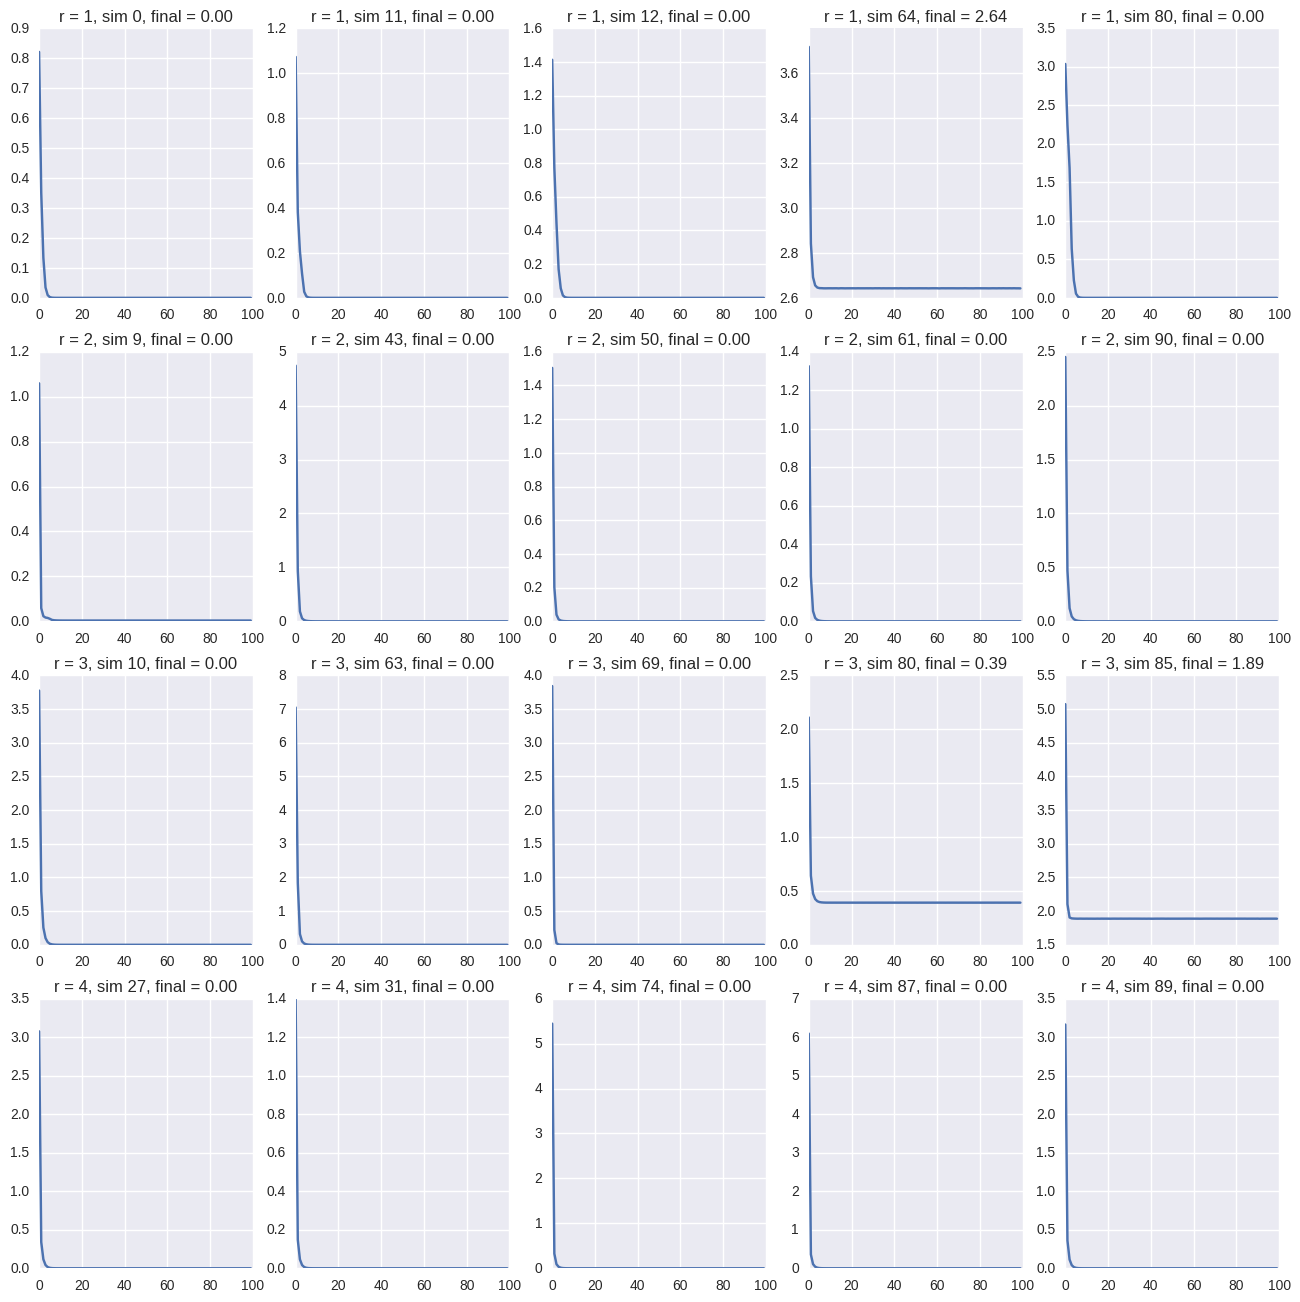

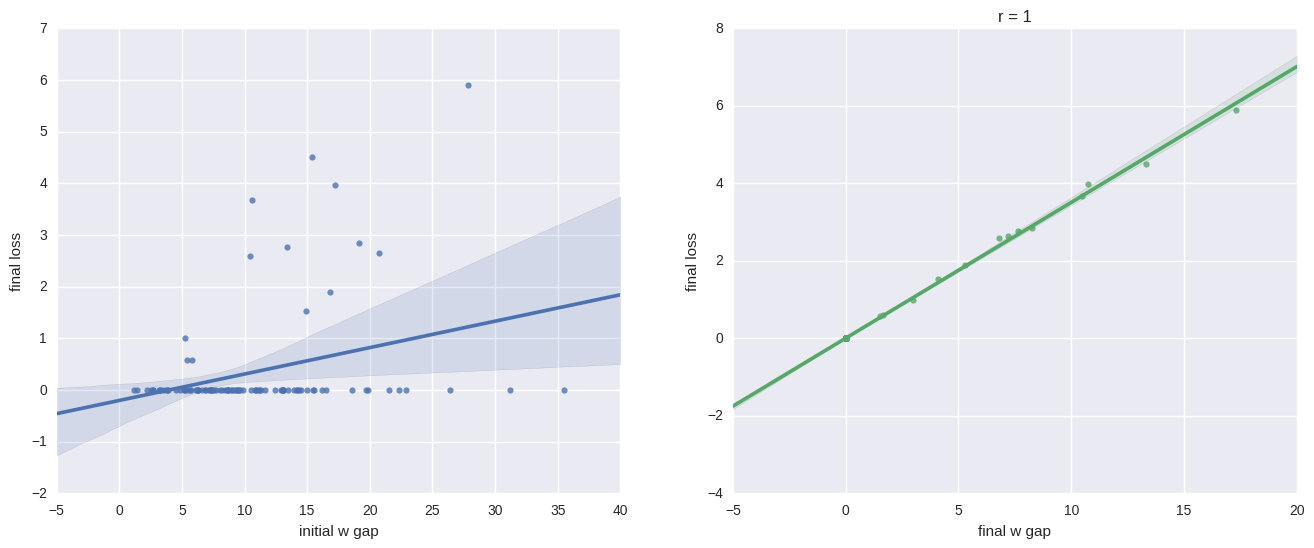

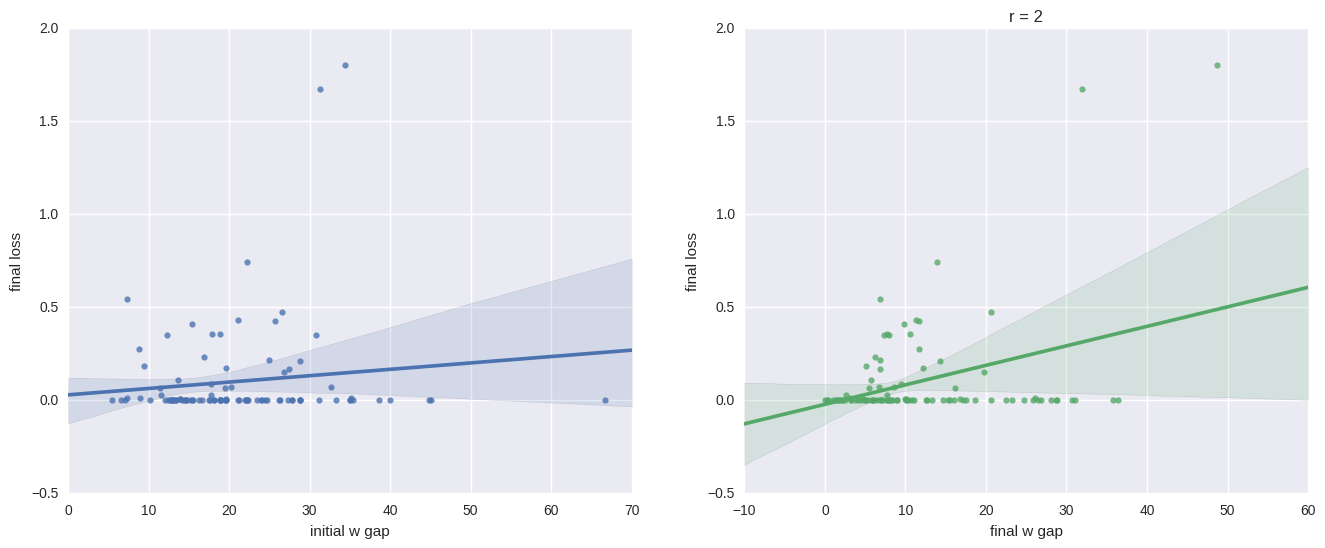

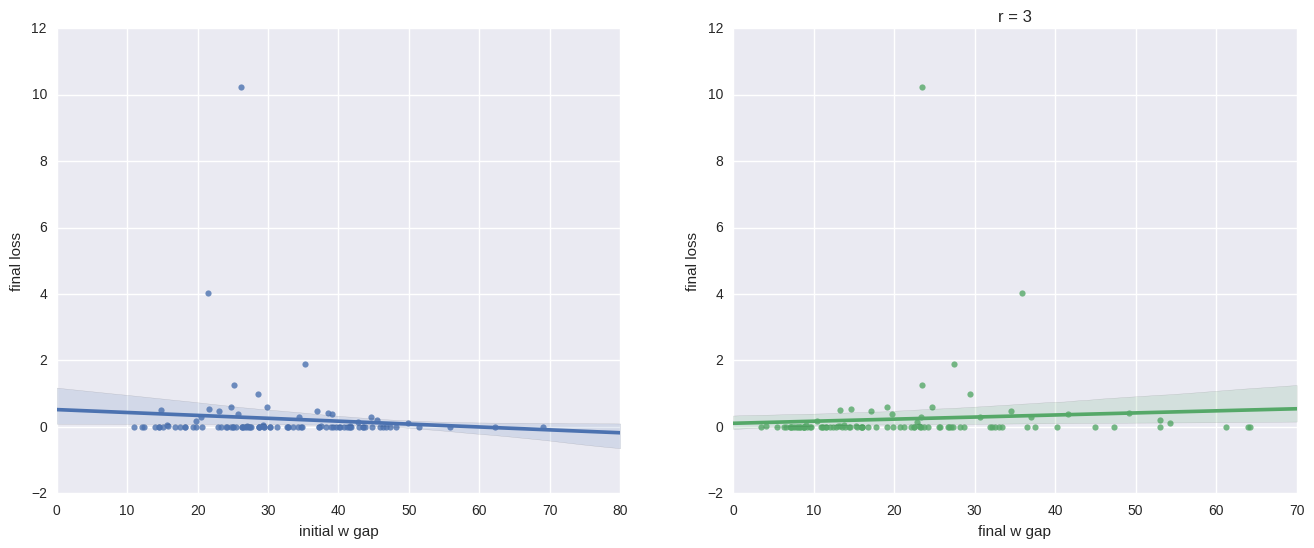

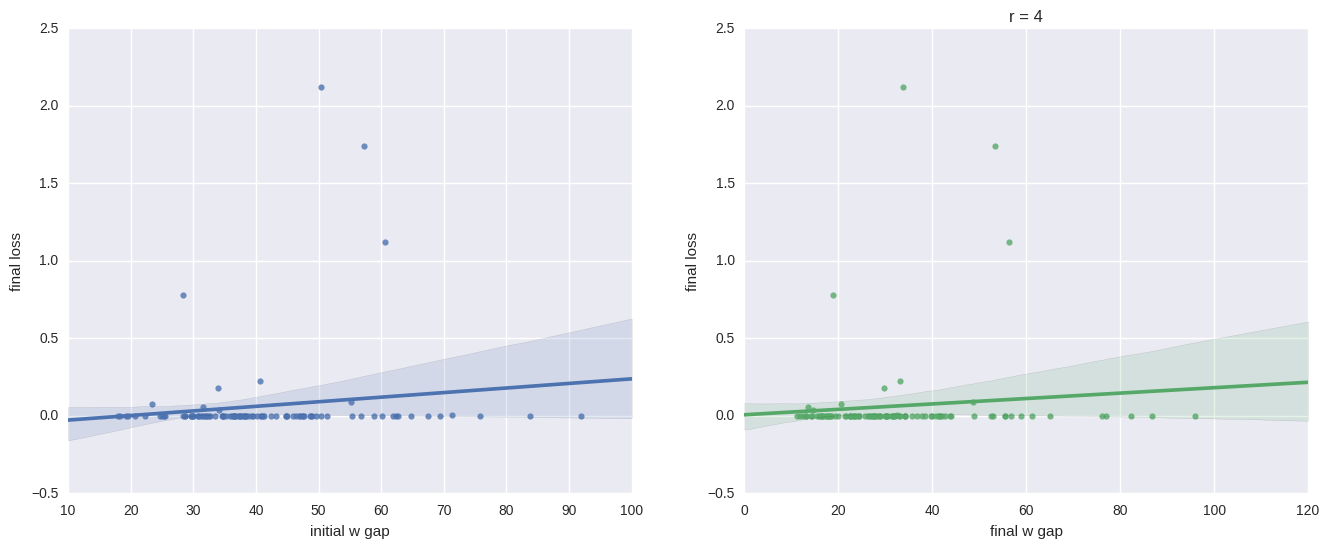

In [10]:
outputs = pickle.load(file('%ssparse_structure_1_p%s/outputs.pickle'%(maindir,p)))

# First look at some random training curves to make sure we've converged
plt.figure(figsize=(16,16))
ind = 1
for i in list_r:
    for j in np.sort(np.random.choice(range(num_sims),5,replace=False)):
        plt.subplot(len(list_r),5,ind)
        plt.plot(outputs[i][j][0])
        plt.title('r = %s, sim %s, final = %.2f'%(i,j,outputs[i][j][0][-1]))
        ind += 1
        
for r in list_r:
    final_losses = np.array([outputs[r][i][-2] for i in range(num_sims)])
    final_w_gaps = np.array([outputs[r][i][-1] for i in range(num_sims)])
    initial_w_gaps = np.array([outputs[r][i][-3] for i in range(num_sims)])
    generate_two_plots(final_losses,final_w_gaps,initial_w_gaps)
    plt.title('r = %s'%(r))

### Sparse structure 2

Each hidden neuron goes to s random inputs

In [11]:
# Sparse structure 2: each hidden neuron goes to s random inputs
def generate_sparse_w_2(p,s,h,seed=0,maskseed=0):
    def sparse_mask_2(p,s,h,seed=0):
        np.random.seed(seed)
        M = np.zeros((h,p))
        for i in range(h):
            M[i,np.random.choice(range(p),s,replace=False)] = 1
        return M
    M = sparse_mask_2(p,s,h,seed=maskseed)
    np.random.seed(seed)
    Z = np.random.normal(0,1./np.sqrt(s),[h,p])
    W1 = (Z*M).T
    W2 = np.ones([h,1])
    return {'weights1':W1,'weights2':W2},M.T

In [12]:
# Case where h > p

num_sims = 100 # number of simulations
N = 10000      # number of samples

# Network parameters
num_epochs = 100
batch_size = 100
build_func = arch.mlp_noreluout_lastlayernottrainable
p = 5    # number of inputs
h = 10   # number of hidden nodes

list_s = range(1,5)
outputs = {s:[] for s in list_s}
start = time.time()

# r = number of neurons each input is connected to
for i,s in enumerate(list_s):

    for t in range(num_sims):

        input_dict = dict(p=p,h=h)
        
        seed = (s-1)*num_sims+t
        savedir = '%ssparse_structure_2_p%s_h%s/initialization_%s_s%s/'%(maindir,p,h,t,s)
    
        # Generate data
        w_true,M = generate_sparse_w_2(p,s,h,seed=seed,maskseed=seed)
        X = dl_utils.generate_X(N,0,input_dict,cov_is_eye=True,seed=seed)
        Y = dl_utils.generate_output(X,w_true,input_dict,build_func=build_func)

        # initialize weights to have desired sparsity structure
        w_init,M = generate_sparse_w_2(p,s,h,seed=seed+1,maskseed=seed)

        # Build graph and train..
        tf.reset_default_graph()
        with tf.device("/gpu:%s"%(gpu_id)):
            graph = graph_builder_wrapper_sparse(input_dict,M,build_func=build_func)
            out = dl_utils.train(X,Y,graph,num_epochs,batch_size,w_true,w_init,
                                 savedir=savedir,verbose=False)
        
        # Save useful information
        outputs[s].append(out)
        
        print('\rr = %s, %s/%s simulations done (%.2f s elapsed)'\
              %(s,t+1,num_sims,time.time()-start),end='')
        
pickle.dump(outputs,file('%ssparse_structure_2_p%s_h%s/outputs.pickle'%(maindir,p,h),'wb'))

r = 4, 100/100 simulations done (3506.95 s elapsed)

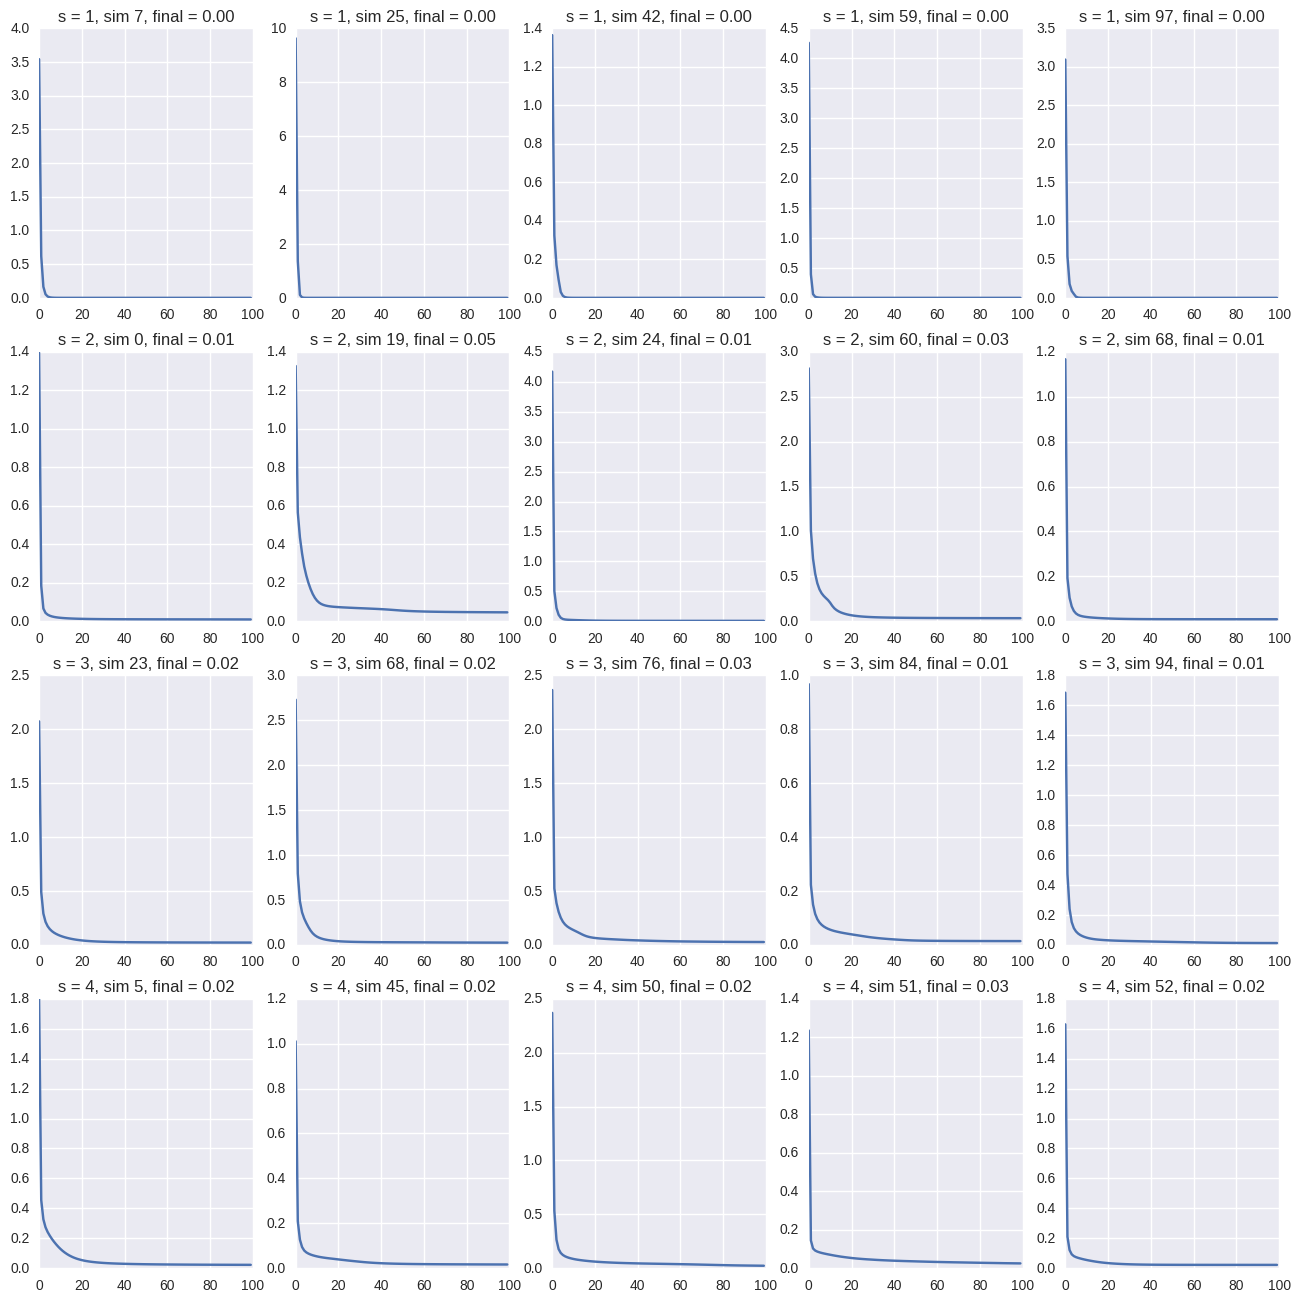

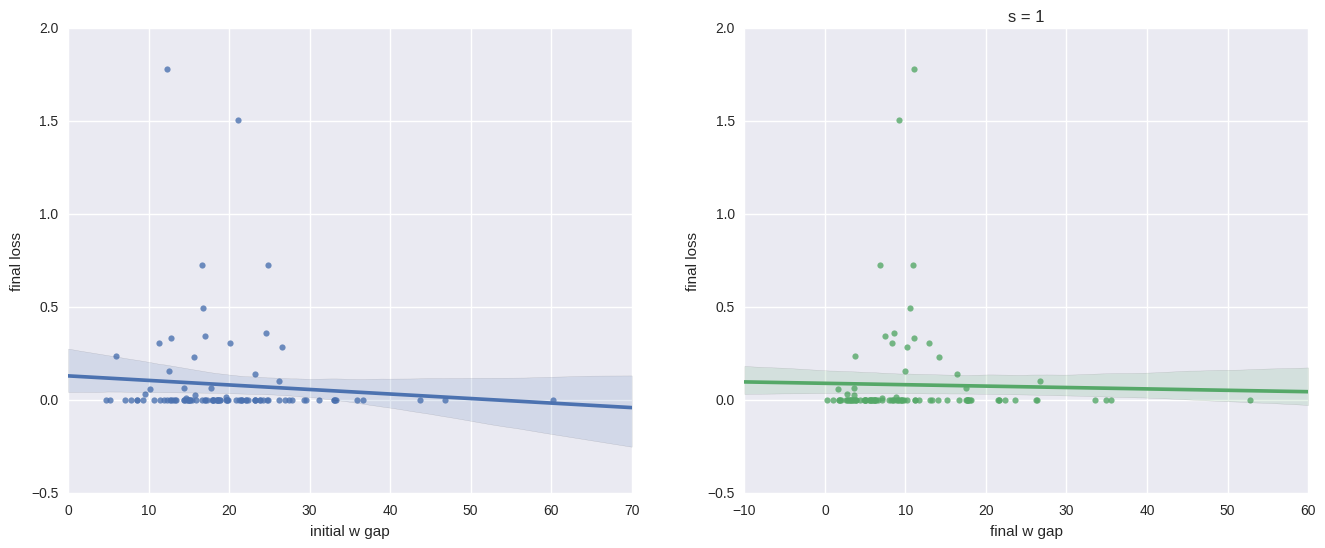

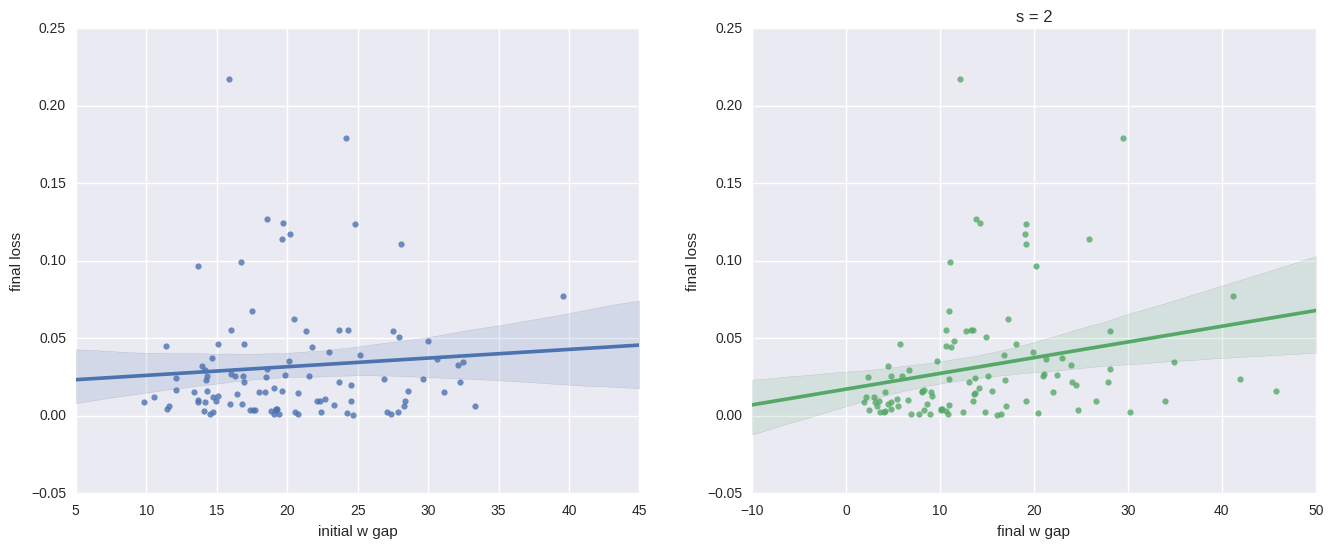

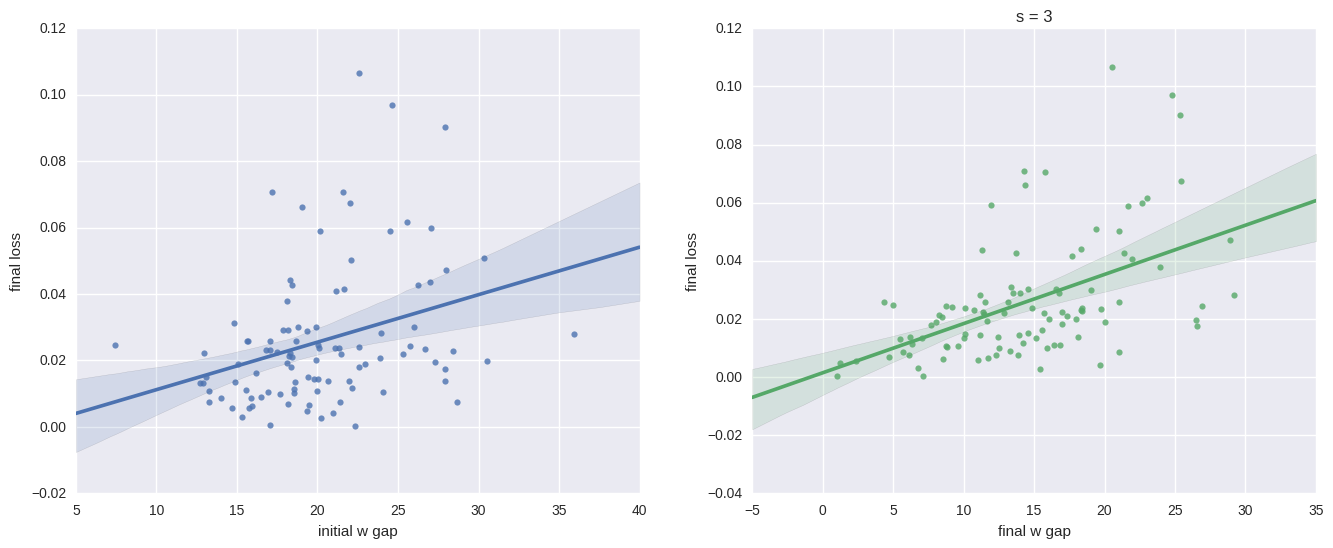

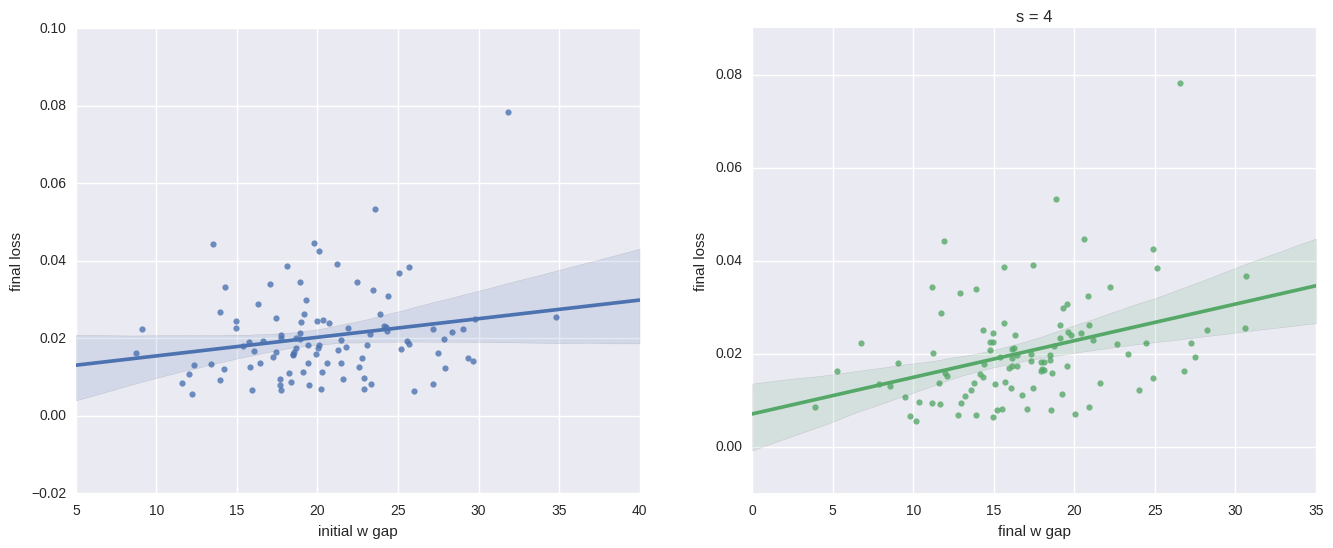

In [13]:
outputs = pickle.load(file('%ssparse_structure_2_p%s_h%s/outputs.pickle'%(maindir,p,h)))

# First look at some random training curves to make sure we've converged
plt.figure(figsize=(16,16))
ind = 1
for i in list_s:
    for j in np.sort(np.random.choice(range(num_sims),5,replace=False)):
        plt.subplot(len(list_s),5,ind)
        plt.plot(outputs[i][j][0])
        plt.title('s = %s, sim %s, final = %.2f'%(i,j,outputs[i][j][0][-1]))
        ind += 1
        
for s in list_s:
    final_losses = np.array([outputs[s][i][-2] for i in range(num_sims)])
    final_w_gaps = np.array([outputs[s][i][-1] for i in range(num_sims)])
    initial_w_gaps = np.array([outputs[s][i][-3] for i in range(num_sims)])
    generate_two_plots(final_losses,final_w_gaps,initial_w_gaps)
    plt.title('s = %s'%(s))

In [14]:
# Case where h > p

num_sims = 100 # number of simulations
N = 10000      # number of samples

# Network parameters
num_epochs = 100
batch_size = 100
build_func = arch.mlp_noreluout_lastlayernottrainable
p = 5    # number of inputs
h = 3    # number of hidden nodes

list_s = range(1,5)
outputs = {s:[] for s in list_s}
start = time.time()

# r = number of neurons each input is connected to
for i,s in enumerate(list_s):
    
    for t in range(num_sims):

        input_dict = dict(p=p,h=h)
        
        seed = (s-1)*num_sims+t
        savedir = '%ssparse_structure_2_p%s_h%s/initialization_%s_s%s/'%(maindir,p,h,t,s)
    
        # Generate data
        w_true,M = generate_sparse_w_2(p,s,h,seed=seed,maskseed=seed)
        X = dl_utils.generate_X(N,0,input_dict,cov_is_eye=True,seed=seed)
        Y = dl_utils.generate_output(X,w_true,input_dict,build_func=build_func)

        # initialize weights to have desired sparsity structure
        w_init,M = generate_sparse_w_2(p,s,h,seed=seed+1,maskseed=seed)

        # Build graph and train..
        tf.reset_default_graph()
        with tf.device("/gpu:%s"%(gpu_id)):
            graph = graph_builder_wrapper_sparse(input_dict,M,build_func=build_func)
            out = dl_utils.train(X,Y,graph,num_epochs,batch_size,w_true,w_init,
                                 savedir=savedir,verbose=False)
        
        # Save useful information
        outputs[s].append(out)
        
        print('\rr = %s, %s/%s simulations done (%.2f s elapsed)'\
              %(s,t+1,num_sims,time.time()-start),end='')
        
pickle.dump(outputs,file('%ssparse_structure_2_p%s_h%s/outputs.pickle'%(maindir,p,h),'wb'))

r = 4, 100/100 simulations done (3515.12 s elapsed)

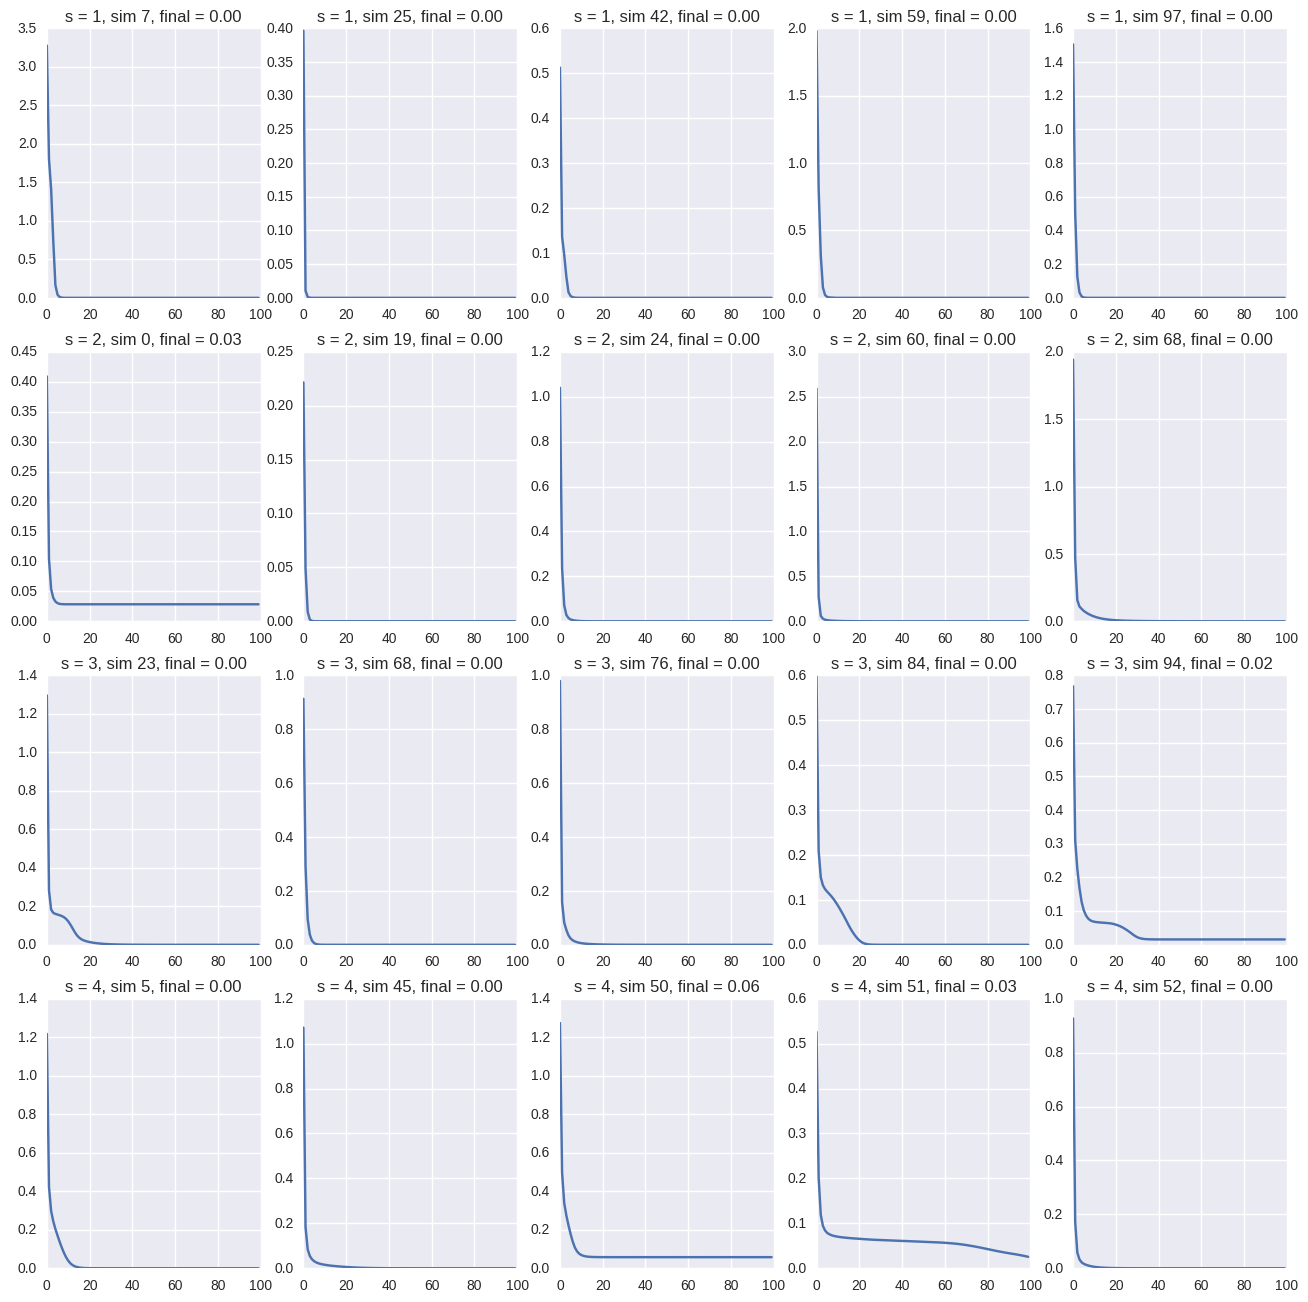

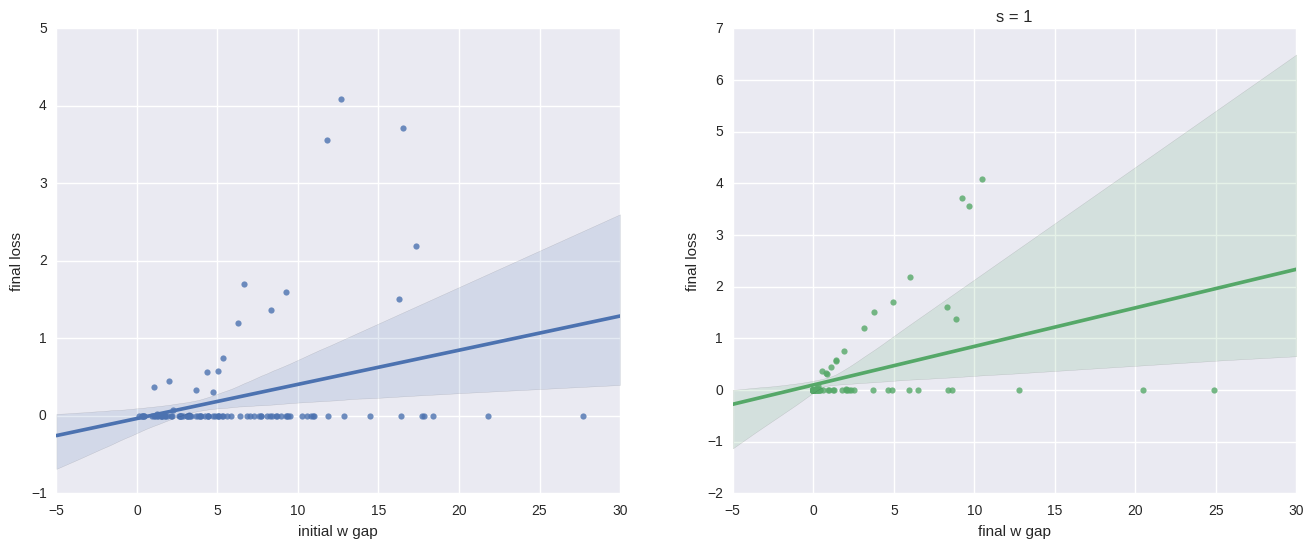

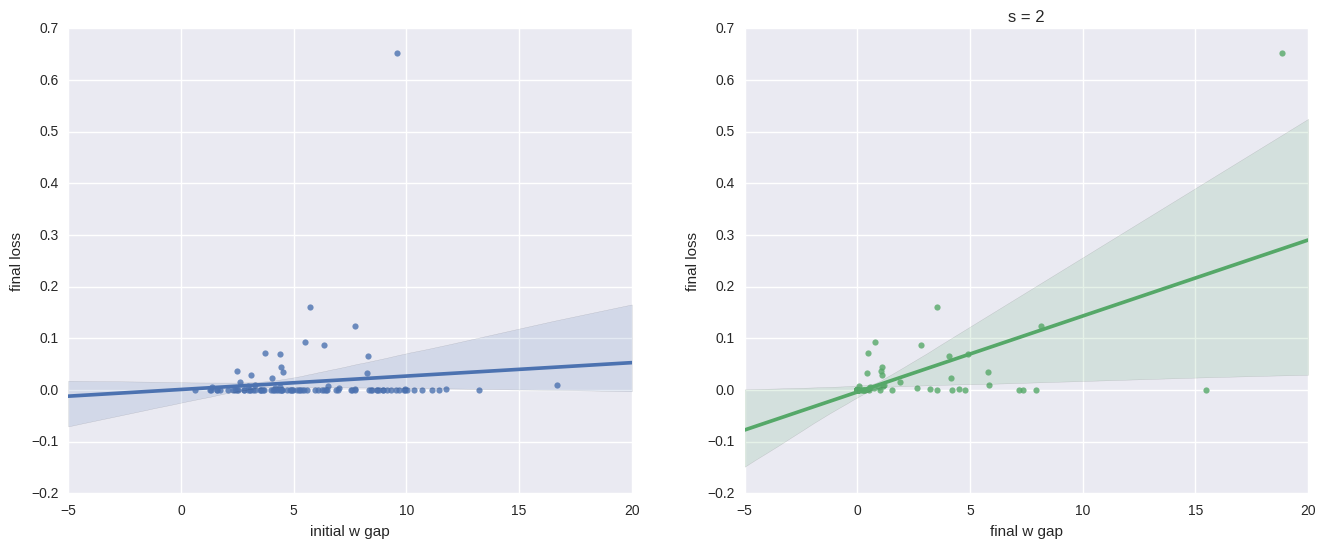

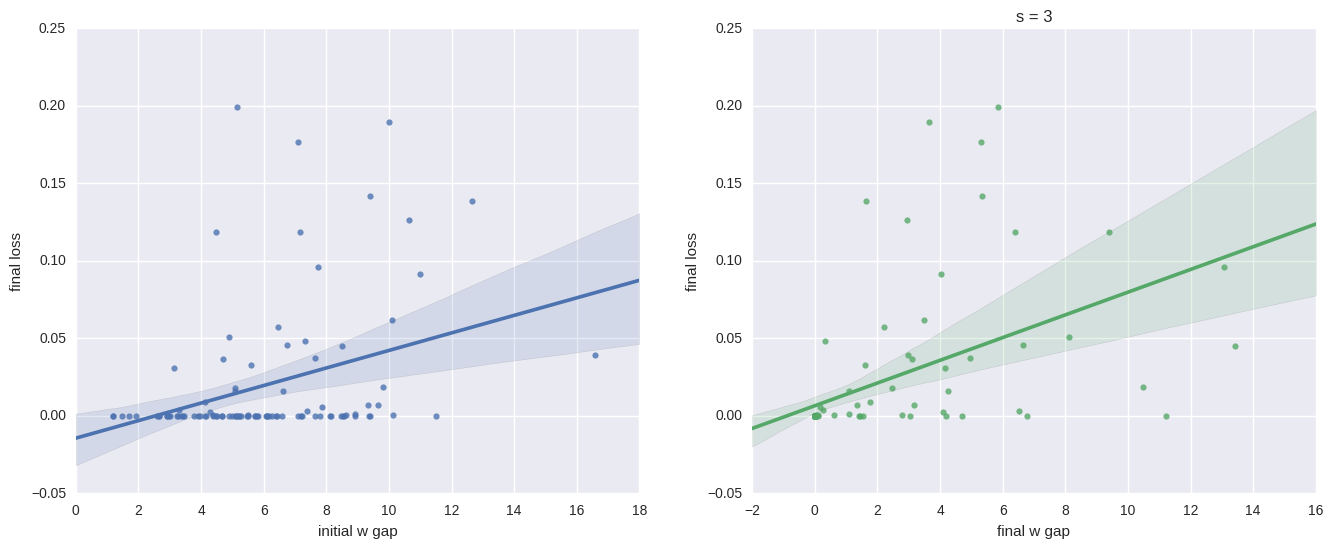

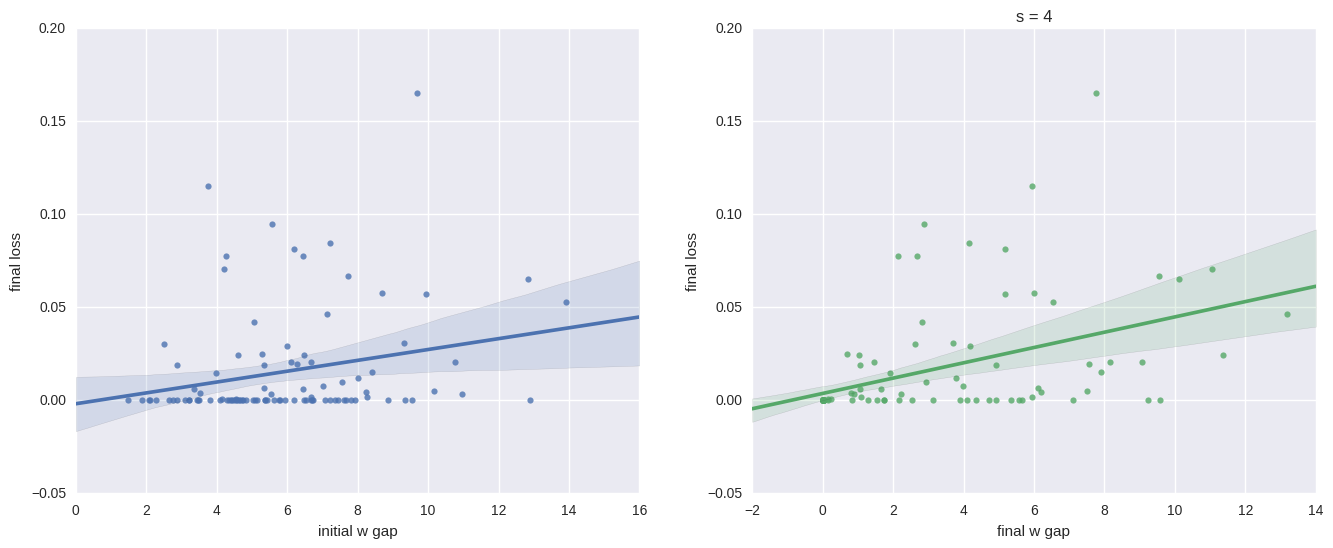

In [15]:
outputs = pickle.load(file('%ssparse_structure_2_p%s_h%s/outputs.pickle'%(maindir,p,h)))

# First look at some random training curves to make sure we've converged
plt.figure(figsize=(16,16))
ind = 1
for i in list_s:
    for j in np.sort(np.random.choice(range(num_sims),5,replace=False)):
        plt.subplot(len(list_s),5,ind)
        plt.plot(outputs[i][j][0])
        plt.title('s = %s, sim %s, final = %.2f'%(i,j,outputs[i][j][0][-1]))
        ind += 1
        
for s in list_s:
    final_losses = np.array([outputs[s][i][-2] for i in range(num_sims)])
    final_w_gaps = np.array([outputs[s][i][-1] for i in range(num_sims)])
    initial_w_gaps = np.array([outputs[s][i][-3] for i in range(num_sims)])
    generate_two_plots(final_losses,final_w_gaps,initial_w_gaps)
    plt.title('s = %s'%(s))

# Experiment set 2: true labels generated with dense architectures

Layer2-layer3 weights all set to 1 still.

In [34]:
# Generate labels using dense networks

np.random.seed(0)
p = 10
h = 3
input_dict = dict(p=p,h=h)
w_true = {'weights1':np.random.normal(0,1./np.sqrt(p),[p,h]),
          'weights2':np.ones([h,1])}

N = 10000
X = dl_utils.generate_X(N,0,input_dict,cov_is_eye=True,seed=seed)
Y = dl_utils.generate_output(X,w_true,input_dict,build_func=arch.mlp_noreluout_lastlayernottrainable)

### Sparse structure 1

In [ ]:
num_attempts = 10 # different initializations may have different performance, so try a few

# Network parameters
num_epochs = 100
batch_size = 100
build_func = arch.mlp_noreluout_lastlayernottrainable

list_r = range(1,5)
outputs = {r:[] for r in list_r}
start = time.time()

# r = number of neurons each input is connected to
for i,r in enumerate(list_r):
    
    for t in range(num_attempts):

        h = p*r  # number of neurons
        input_dict = dict(p=p,h=h)

        seed = (r-1)*num_sims+t
        savedir = '%ssparse_structure_1_p%s_denselabels/initialization_%s_r%s/'%(maindir,p,t,r)

        # initialize weights to have desired sparsity structure
        w_init,M = generate_sparse_w_1(p,r,seed=seed)

        # Build graph and train..
        tf.reset_default_graph()
        with tf.device("/gpu:%s"%(gpu_id)):
            graph = graph_builder_wrapper_sparse(input_dict,M,build_func=build_func)
            out = dl_utils.train(X,Y,graph,num_epochs,batch_size,w_init,w_init,savedir=savedir)

        # Save useful information
        outputs[r].append(out)

pickle.dump(outputs,file('%ssparse_structure_1_p%s_denselabels/outputs.pickle'%(maindir,p),'wb'))

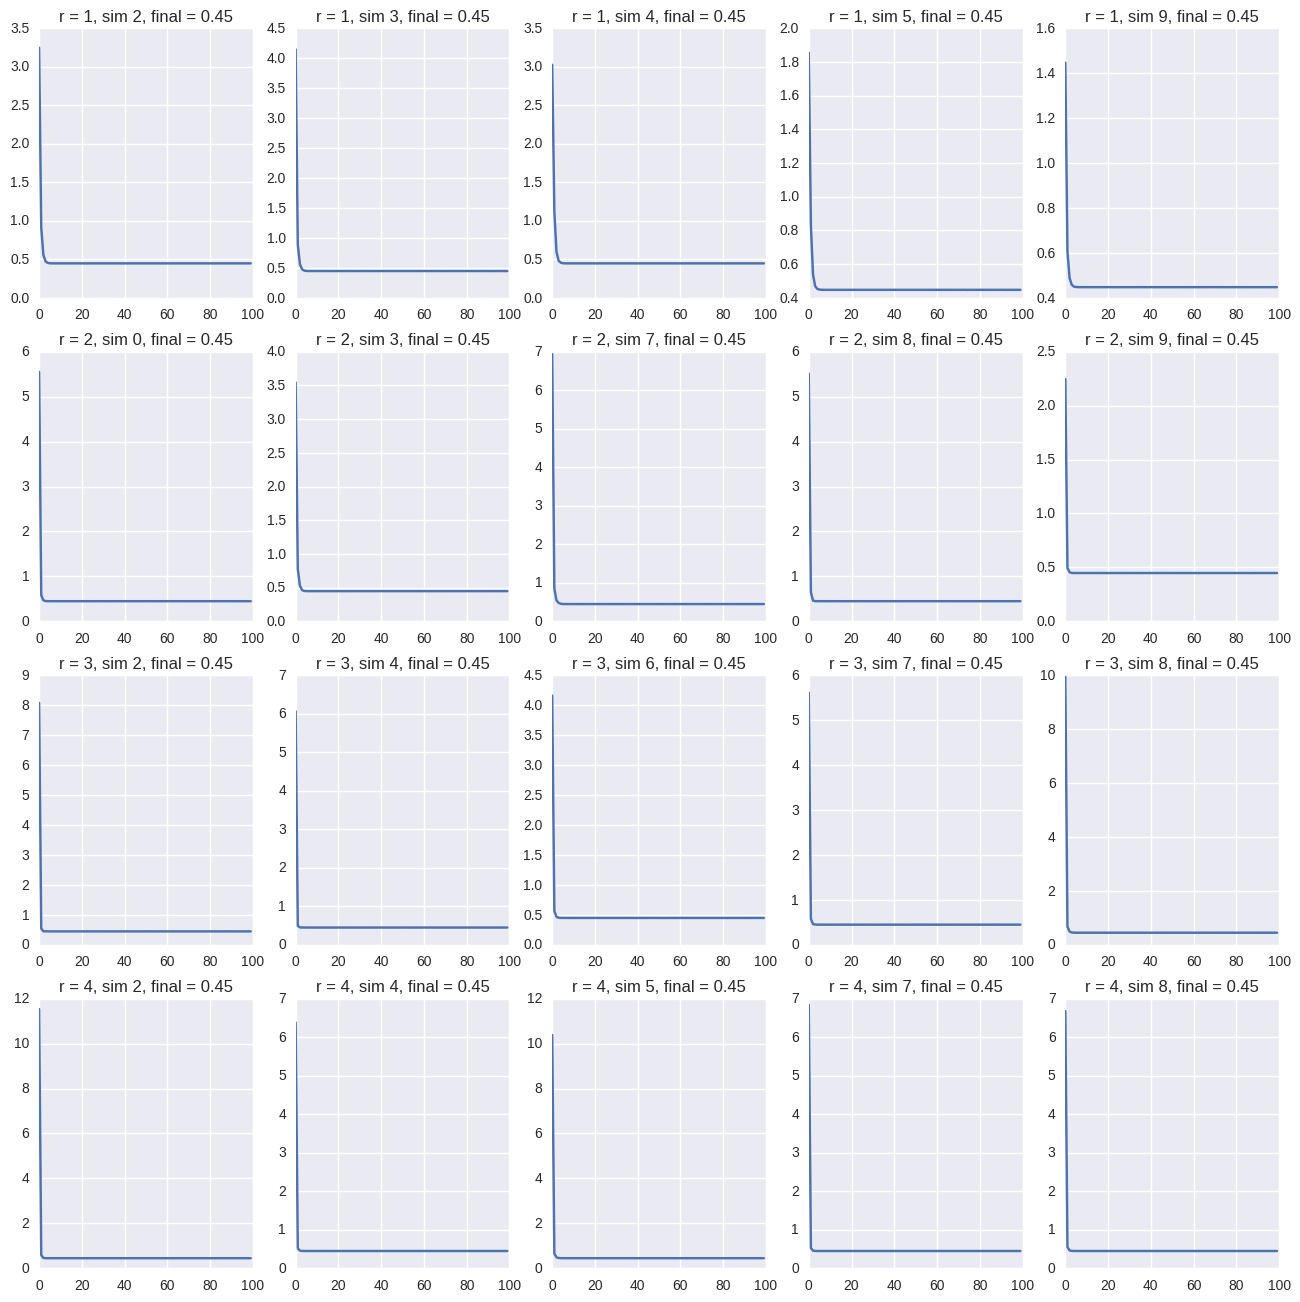

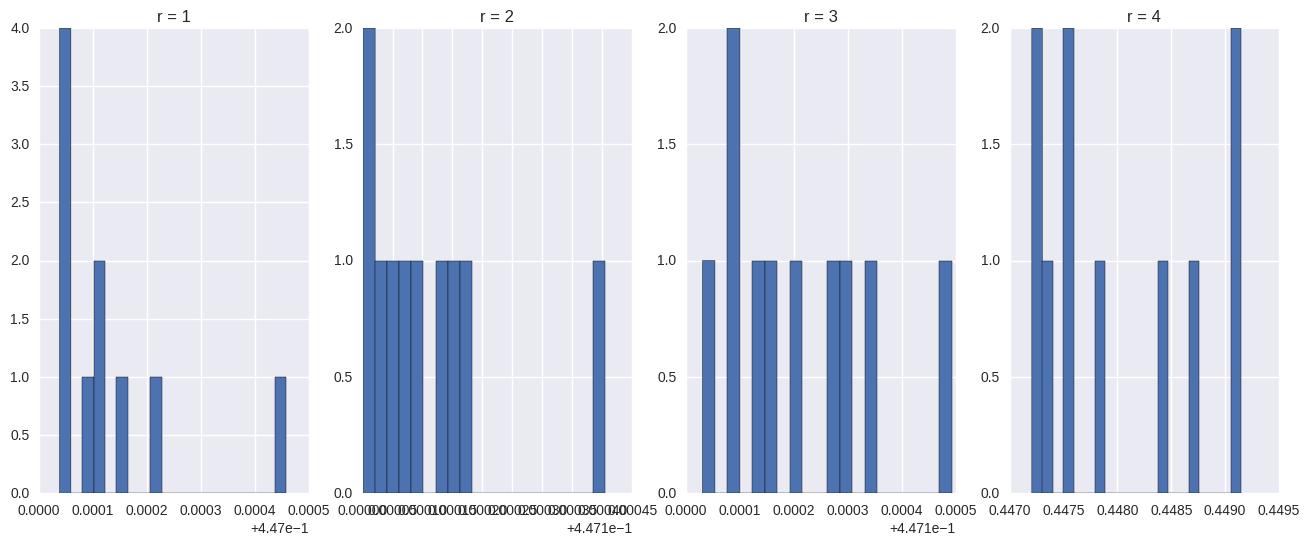

In [43]:
outputs = pickle.load(file('%ssparse_structure_1_p%s_denselabels/outputs.pickle'%(maindir,p)))

# First look at some random training curves to make sure we've converged
plt.figure(figsize=(16,16))
ind = 1
for i in list_r:
    for j in np.sort(np.random.choice(range(num_attempts),5,replace=False)):
        plt.subplot(len(list_r),5,ind)
        plt.plot(outputs[i][j][0])
        plt.title('r = %s, sim %s, final = %.2f'%(i,j,outputs[i][j][0][-1]))
        ind += 1
        
plt.figure(figsize=(16,6))
for i,r in enumerate(list_r):
    plt.subplot(1,len(list_r),i+1)
    final_losses = np.array([outputs[r][i][-2] for i in range(num_attempts)])
    plt.hist(final_losses,bins=20)
    plt.title('r = %s'%(r))

### Sparse structure 2

In [ ]:
# Case where h < p

num_attempts = 100 # different initializations may have different performance, so try a few

# Network parameters
num_epochs = 100
batch_size = 100
build_func = arch.mlp_noreluout_lastlayernottrainable

h = 3    # number of hidden nodes

list_s = range(1,9)
outputs = {s:[] for s in list_s}
start = time.time()

# r = number of neurons each input is connected to
for i,s in enumerate(list_s):
    
    for t in range(num_attempts):

        input_dict = dict(p=p,h=h)

        seed = (s-1)*num_sims+t
        savedir = '%ssparse_structure_2_p%s_h%s_denselabels/initialization_%s_s%s/'%(maindir,p,h,t,s)

        # initialize weights to have desired sparsity structure
        w_init,M = generate_sparse_w_2(p,s,h,seed=seed+1,maskseed=seed)

        # Build graph and train..
        tf.reset_default_graph()
        with tf.device("/gpu:%s"%(gpu_id)):
            graph = graph_builder_wrapper_sparse(input_dict,M,build_func=build_func)
            out = dl_utils.train(X,Y,graph,num_epochs,batch_size,w_init,w_init,savedir=savedir)

        # Save useful information
        outputs[s].append(out)

pickle.dump(outputs,file('%ssparse_structure_2_p%s_h%s_denselabels/outputs.pickle'%(maindir,p,h),'wb'))

Epoch 3/100 (0.268 s), batch 7.0/100 (0.006 s): loss 2.083, w gap: 0.172

Epoch 4/100 (0.465 s), batch 100.0/100 (0.104 s): loss 2.813, w gap: 0.265

Epoch 6/100 (0.668 s), batch 100.0/100 (0.101 s): loss 2.602, w gap: 0.303

Epoch 9/100 (0.873 s), batch 15.0/100 (0.014 s): loss 2.043, w gap: 0.327

Epoch 11/100 (1.074 s), batch 43.0/100 (0.037 s): loss 2.236, w gap: 0.307

Epoch 13/100 (1.275 s), batch 52.0/100 (0.050 s): loss 2.436, w gap: 0.323

Epoch 15/100 (1.476 s), batch 71.0/100 (0.062 s): loss 2.121, w gap: 0.325

Epoch 17/100 (1.677 s), batch 81.0/100 (0.078 s): loss 1.865, w gap: 0.329

Epoch 19/100 (1.877 s), batch 89.0/100 (0.086 s): loss 2.092, w gap: 0.325

Epoch 21/100 (2.079 s), batch 76.0/100 (0.077 s): loss 1.846, w gap: 0.331

Epoch 23/100 (2.280 s), batch 75.0/100 (0.076 s): loss 2.018, w gap: 0.329

Epoch 25/100 (2.480 s), batch 84.0/100 (0.081 s): loss 1.936, w gap: 0.329

Epoch 28/100 (2.682 s), batch 7.0/100 (0.008 s): loss 2.412, w gap: 0.316

Epoch 30/100 (2.883 s), batch 36.0/100 (0.032 s): loss 1.662, w gap: 0.321

Epoch 32/100 (3.084 s), batch 40.0/100 (0.035 s): loss 2.010, w gap: 0.314

Epoch 34/100 (3.285 s), batch 40.0/100 (0.038 s): loss 1.801, w gap: 0.325

Epoch 36/100 (3.486 s), batch 44.0/100 (0.042 s): loss 2.132, w gap: 0.315

Epoch 38/100 (3.687 s), batch 44.0/100 (0.037 s): loss 1.868, w gap: 0.323

Epoch 40/100 (3.888 s), batch 54.0/100 (0.050 s): loss 2.415, w gap: 0.316

Epoch 42/100 (4.089 s), batch 52.0/100 (0.050 s): loss 2.566, w gap: 0.314

Epoch 44/100 (4.290 s), batch 48.0/100 (0.047 s): loss 2.941, w gap: 0.316

Epoch 46/100 (4.490 s), batch 75.0/100 (0.064 s): loss 2.694, w gap: 0.327

Epoch 48/100 (4.692 s), batch 96.0/100 (0.087 s): loss 1.979, w gap: 0.332

Epoch 50/100 (4.893 s), batch 92.0/100 (0.088 s): loss 2.712, w gap: 0.320

Epoch 52/100 (5.094 s), batch 95.0/100 (0.084 s): loss 1.919, w gap: 0.323

Epoch 54/100 (5.296 s), batch 88.0/100 (0.093 s): loss 1.774, w gap: 0.313

Epoch 56/100 (5.496 s), batch 79.0/100 (0.076 s): loss 1.627, w gap: 0.322

Epoch 58/100 (5.697 s), batch 68.0/100 (0.073 s): loss 1.810, w gap: 0.319

Epoch 60/100 (5.898 s), batch 55.0/100 (0.063 s): loss 1.175, w gap: 0.334

Epoch 62/100 (6.099 s), batch 68.0/100 (0.058 s): loss 2.342, w gap: 0.328

Epoch 64/100 (6.298 s), batch 100.0/100 (0.082 s): loss 2.636, w gap: 0.327

Epoch 67/100 (6.504 s), batch 7.0/100 (0.006 s): loss 1.856, w gap: 0.326

Epoch 69/100 (6.705 s), batch 12.0/100 (0.011 s): loss 2.140, w gap: 0.326

Epoch 71/100 (6.903 s), batch 1.0/100 (0.001 s): loss 3.070, w gap: 0.326

Epoch 73/100 (7.109 s), batch 2.0/100 (0.003 s): loss 1.724, w gap: 0.323

Epoch 74/100 (7.310 s), batch 97.0/100 (0.096 s): loss 2.313, w gap: 0.328

Epoch 76/100 (7.511 s), batch 95.0/100 (0.086 s): loss 2.054, w gap: 0.333

Epoch 78/100 (7.712 s), batch 95.0/100 (0.086 s): loss 2.190, w gap: 0.329

Epoch 81/100 (7.925 s), batch 19.0/100 (0.015 s): loss 1.734, w gap: 0.303

Epoch 83/100 (8.126 s), batch 32.0/100 (0.029 s): loss 1.615, w gap: 0.317

Epoch 85/100 (8.326 s), batch 33.0/100 (0.028 s): loss 2.425, w gap: 0.308

Epoch 87/100 (8.529 s), batch 33.0/100 (0.033 s): loss 1.920, w gap: 0.318

Epoch 89/100 (8.727 s), batch 29.0/100 (0.024 s): loss 1.819, w gap: 0.329

Epoch 91/100 (8.936 s), batch 22.0/100 (0.020 s): loss 2.799, w gap: 0.321

Epoch 93/100 (9.136 s), batch 9.0/100 (0.007 s): loss 2.629, w gap: 0.332

Epoch 94/100 (9.337 s), batch 99.0/100 (0.104 s): loss 2.379, w gap: 0.316

Epoch 97/100 (9.537 s), batch 6.0/100 (0.005 s): loss 2.451, w gap: 0.322

Epoch 99/100 (9.742 s), batch 31.0/100 (0.023 s): loss 2.277, w gap: 0.336

Epoch 100/100 (9.897 s), batch 100.0/100 (0.089 s): loss 2.098, w gap: 0.313


Epoch 100/100 (10.012 s), batch 100.0/100 (0.099 s): loss 1.300, w gap: 5.493
Epoch 100/100 (9.682 s), batch 100.0/100 (0.092 s): loss 1.581, w gap: 1.842
Epoch 100/100 (9.870 s), batch 100.0/100 (0.094 s): loss 2.201, w gap: 2.966
Epoch 100/100 (9.681 s), batch 100.0/100 (0.084 s): loss 2.631, w gap: 2.157
Epoch 100/100 (9.833 s), batch 100.0/100 (0.102 s): loss 1.904, w gap: 1.324
Epoch 100/100 (9.931 s), batch 100.0/100 (0.086 s): loss 1.165, w gap: 1.721
Epoch 100/100 (9.840 s), batch 100.0/100 (0.092 s): loss 2.167, w gap: 0.318
Epoch 100/100 (9.865 s), batch 100.0/100 (0.091 s): loss 2.176, w gap: 0.309
Epoch 100/100 (9.831 s), batch 100.0/100 (0.098 s): loss 1.403, w gap: 8.697
Epoch 100/100 (9.884 s), batch 100.0/100 (0.092 s): loss 2.658, w gap: 0.897
Epoch 100/100 (9.931 s), batch 100.0/100 (0.093 s): loss 2.416, w gap: 1.165
Epoch 100/100 (9.843 s), batch 100.0/100 (0.093 s): loss 2.540, w gap: 0.443
Epoch 100/100 (9.978 s), batch 100.0/100 (0.101 s): loss 2.161, w gap: 2.4

In [ ]:
outputs = pickle.load(file('%ssparse_structure_2_p%s_h%s_denselabels/outputs.pickle'%(maindir,p,h)))

# First look at some random training curves to make sure we've converged
plt.figure(figsize=(16,16))
ind = 1
for i in list_s:
    for j in np.sort(np.random.choice(range(num_attempts),5,replace=False)):
        plt.subplot(len(list_s),5,ind)
        plt.plot(outputs[i][j][0])
        plt.title('s = %s, sim %s, final = %.2f'%(i,j,outputs[i][j][0][-1]))
        ind += 1
        
plt.figure(figsize=(16,6))
for i,s in enumerate(list_s):
    plt.subplot(1,len(list_s),i+1)
    final_losses = np.array([outputs[s][i][-2] for i in range(num_attempts)])
    plt.hist(final_losses,bins=20)
    plt.title('s = %s'%(s))

In [ ]:
# Case where h < p

num_attempts = 100 # different initializations may have different performance, so try a few

# Network parameters
num_epochs = 100
batch_size = 100
build_func = arch.mlp_noreluout_lastlayernottrainable

h = 15    # number of hidden nodes

list_s = range(1,9)
outputs = {s:[] for s in list_s}
start = time.time()

# r = number of neurons each input is connected to
for i,s in enumerate(list_s):
    
    for t in range(num_attempts):

        input_dict = dict(p=p,h=h)

        seed = (s-1)*num_sims+t
        savedir = '%ssparse_structure_2_p%s_h%s_denselabels/initialization_%s_s%s/'%(maindir,p,h,t,s)

        # initialize weights to have desired sparsity structure
        w_init,M = generate_sparse_w_2(p,s,h,seed=seed+1,maskseed=seed)

        # Build graph and train..
        tf.reset_default_graph()
        with tf.device("/gpu:%s"%(gpu_id)):
            graph = graph_builder_wrapper_sparse(input_dict,M,build_func=build_func)
            out = dl_utils.train(X,Y,graph,num_epochs,batch_size,w_init,w_init,savedir=savedir)

        # Save useful information
        outputs[s].append(out)

pickle.dump(outputs,file('%ssparse_structure_2_p%s_h%s_denselabels/outputs.pickle'%(maindir,p,h),'wb'))

In [ ]:
outputs = pickle.load(file('%ssparse_structure_2_p%s_h%s_denselabels/outputs.pickle'%(maindir,p,h)))

# First look at some random training curves to make sure we've converged
plt.figure(figsize=(16,16))
ind = 1
for i in list_s:
    for j in np.sort(np.random.choice(range(num_attempts),5,replace=False)):
        plt.subplot(len(list_s),5,ind)
        plt.plot(outputs[i][j][0])
        plt.title('s = %s, sim %s, final = %.2f'%(i,j,outputs[i][j][0][-1]))
        ind += 1
        
plt.figure(figsize=(16,6))
for i,s in enumerate(list_s):
    plt.subplot(1,len(list_s),i+1)
    final_losses = np.array([outputs[s][i][-2] for i in range(num_attempts)])
    plt.hist(final_losses,bins=20)
    plt.title('s = %s'%(s))